<a href="https://colab.research.google.com/github/Hasnafi/Hyper-heuristic/blob/main/Hyperheuristique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solution du problème TCP avec les Hyper-heuristiques**

L'hyper-heuristique dans ce code combine l'algorithme de colonie de fourmis (ACO) au niveau supérieur avec trois heuristiques de construction au niveau inférieur pour résoudre le problème du voyageur de commerce (TSP). Voici une explication du principe de cette hyperheuristique :

**1. Algorithme de Colonie de Fourmis (ACO) - Niveau Supérieur**
ACO est un algorithme inspiré du comportement des fourmis réelles qui cherchent de la nourriture.

**2. Heuristiques de Construction - Niveau Inférieur**
Au niveau inférieur, trois heuristiques sont utilisées pour construire partiellement les tournées des fourmis :

  * *Nearest Neighbor Partial (Plus Proche Voisin Partiel) :* Sélectionne la ville la plus proche non encore visitée et l'ajoute à la tournée.
  * *Random Insertion Partial (Insertion Aléatoire Partielle) :* Sélectionne une ville non encore visitée aléatoirement et l'insère à la position qui minimise l'augmentation du coût de la tournée.
  * *Farthest Insertion Partial (Insertion de la Ville la Plus Éloignée Partielle) :* Sélectionne la ville non encore visitée la plus éloignée et l'insère à la position qui minimise l'augmentation du coût de la tournée.

# **Comparaison**

| Aspect                           | nearest_neighbor_partial | farthest_insertion_partial | random_insertion_partial |
|----------------------------------|---------------------------|----------------------------|--------------------------|
| **Diversité des solutions générées**  | faible (solutions similaires) | Elevée                     | Elevée                   |
| **Qualité des solutions**        | moyenne                   | Bonne                      | Variable                 |
| **Robustesse**                   | Elevée                    | moyenne                    | moyenne                  |
| **Temps d'exécution**            | Faible                    | Modéré                     | Modéré                   |


**1. Importation des bibliothèques**

In [ ]:
# Importer les bibliothèques nécessaires
import numpy as np
import random
import time

**2. Lecture des données du fichier TSP**

Cette fonction lit un fichier TSP et extrait les coordonnées des villes. Elle suppose que chaque ligne contient un identifiant de ville et deux coordonnées (x, y).

In [ ]:
# Fonction pour lire un fichier TSP
def lire_fichier_tsp(nom_fichier):
    coordinates = []
    with open(nom_fichier, 'r') as fichier:
        for ligne in fichier:
            parts = ligne.split()
            if len(parts) == 3:
                try:
                    coordinates.append((float(parts[1]), float(parts[2])))
                except ValueError:
                    pass
    return coordinates

**3. Calcul de la matrice des distances**

Cette fonction calcule la matrice des distances euclidiennes entre toutes les paires de villes


In [ ]:
# Fonction pour calculer la matrice des distances
def compute_distance_matrix(coordinates):
    n = len(coordinates)
    distance_matrix = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1 = coordinates[i]
            x2, y2 = coordinates[j]
            distance = np.hypot(x1 - x2, y1 - y2)
            distance_matrix[i][j] = round(distance, 2)
            distance_matrix[j][i] = round(distance, 2)
    return distance_matrix

**4. Évaluation d'une tournée**

Cette fonction calcule le coût total d'une tournée en sommant les distances entre les villes successives.

In [ ]:
# Fonction pour évaluer une tournée
def evaluate_tour(tour, distances):
    return sum(distances[tour[i]][tour[i + 1]] for i in range(len(tour) - 1)) + distances[tour[-1]][tour[0]]

**5. Fonctions heuristiques pour le TSP**

  * *Nearest Neighbor Partial (Plus Proche Voisin Partiel) :* Sélectionne la ville la plus proche non encore visitée et l'ajoute à la tournée.
  * *Random Insertion Partial (Insertion Aléatoire Partielle) :* Sélectionne une ville non encore visitée aléatoirement et l'insère à la position qui minimise l'augmentation du coût de la tournée.
  * *Farthest Insertion Partial (Insertion de la Ville la Plus Éloignée Partielle) :* Sélectionne la ville non encore visitée la plus éloignée et l'insère à la position qui minimise l'augmentation du coût de la tournée.

In [ ]:
# Fonctions heuristiques pour le TSP
def nearest_neighbor_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]
    current_city = tour[-1]
    next_city = min(unvisited, key=lambda city: distances[current_city][city])
    unvisited.remove(next_city)
    return tour + [next_city]

def random_insertion_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]
    next_city = random.choice(list(unvisited))
    best_position = min(range(len(tour) + 1), key=lambda i: distances[tour[i - 1]][next_city] + distances[next_city][tour[i % len(tour)]] - distances[tour[i - 1]][tour[i % len(tour)]])
    tour.insert(best_position, next_city)
    unvisited.remove(next_city)
    return tour

def farthest_insertion_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]
    if len(tour) == 1:
        farthest_city = max(unvisited, key=lambda city: distances[tour[0]][city])
        unvisited.remove(farthest_city)
        return tour + [farthest_city]
    best_city = None
    best_position = None
    max_distance = -1
    for city in unvisited:
        for i in range(len(tour)):
            distance = distances[city][tour[i]]
            if distance > max_distance:
                max_distance = distance
                best_city = city
    if best_city is not None:
        best_position = min(range(len(tour) + 1), key=lambda i: distances[tour[i - 1]][best_city] + distances[best_city][tour[i % len(tour)]] - distances[tour[i - 1]][tour[i % len(tour)]])
        tour.insert(best_position, best_city)
        unvisited.remove(best_city)
    return tour

**6. Classe représentant une fourmi**

Cette classe représente une fourmi qui construit une tournée en utilisant une séquence aléatoire de heuristiques.

In [ ]:
# Classe représentant une fourmi dans l'algorithme ACO
class Ant:
    def __init__(self, n, heuristics):
        self.tour = []
        self.unvisited = set(range(n))
        self.heuristic_sequence = random.choices(heuristics, k=n)
        self.n = n

    def construct_tour(self, distances):
        for heuristic in self.heuristic_sequence:
            self.tour = heuristic(self.tour, distances, self.unvisited)
        return self.tour

**7. Classe pour l'hyper-heuristique avec ACO**


In [ ]:
# Classe pour l'hyper-heuristique ACO
class ACOHyperHeuristic:
    def __init__(self, distances, num_ants=100, alpha=1.0, beta=2.0, rho=0.1, pheromone_init=1.0):
        self.distances = distances
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.n = len(distances)
        self.heuristics = [
            nearest_neighbor_partial,
            farthest_insertion_partial,
            random_insertion_partial
        ]
        self.pheromone = np.full((self.n, len(self.heuristics)), pheromone_init)
        self.best_tour = None
        self.best_cost = float('inf')

    # Mise à jour locale des phéromones
    def local_pheromone_update(self, heuristic_index):
        self.pheromone[:, heuristic_index] *= (1 - self.rho)

    # Mise à jour globale des phéromones
    def global_pheromone_update(self, best_heuristic_sequence):
        for i, heuristic in enumerate(best_heuristic_sequence):
            heuristic_index = self.heuristics.index(heuristic)
            self.pheromone[:, heuristic_index] += self.best_cost

    # Sélection d'une heuristique basée sur les probabilités
    def select_heuristic(self, probabilities):
        return np.random.choice(self.heuristics, p=probabilities)

    # Exécution de l'algorithme ACO
    def run(self, max_iterations=100):
        for iteration in range(max_iterations):
            all_tours = []
            all_costs = []
            for _ in range(self.num_ants):
                ant = Ant(self.n, self.heuristics)
                tour = ant.construct_tour(self.distances)
                cost = evaluate_tour(tour, self.distances)
                all_tours.append(tour)
                all_costs.append(cost)
                for heuristic in ant.heuristic_sequence:
                    heuristic_index = self.heuristics.index(heuristic)
                    self.local_pheromone_update(heuristic_index)
            min_cost_index = np.argmin(all_costs)
            if all_costs[min_cost_index] < self.best_cost:
                self.best_tour = all_tours[min_cost_index]
                self.best_cost = all_costs[min_cost_index]
                self.global_pheromone_update(ant.heuristic_sequence)

**11. Fonction principale**

In [ ]:
# Fonction principale
def main():
    # Commencer le calcul du temps
    start_time = time.time()

    # Lire les coordonnées des villes et calculer la matrice des distances
    coordinates = lire_fichier_tsp("pr76.tsp")
    distances = compute_distance_matrix(coordinates)

    # Initialiser et exécuter l'algorithme ACO hyper-heuristique
    aco_hyper_heuristic = ACOHyperHeuristic(distances)
    aco_hyper_heuristic.run(max_iterations=200)

    # Calculer le temps total d'exécution
    end_time = time.time()
    execution_time = end_time - start_time

    # Afficher les résultats
    print("Best cost found:", aco_hyper_heuristic.best_cost)
    print(f"Execution time: {execution_time:.2f} seconds")

if __name__ == "__main__":
    main()


Best cost found: 112278.09
Execution time: 259.79 seconds


# l'Hyperheuristique de Recuit Simulé
L'hyperheuristique de recuit simulé est une méthode d'optimisation qui combine plusieurs heuristiques pour résoudre le problème du voyageur de commerce (TSP).

In [ ]:
import numpy as np
import random
import math

def lire_fichier_tsp(nom_fichier):
    coordinates = []
    with open(nom_fichier, 'r') as fichier:
        for ligne in fichier:
            parts = ligne.split()
            if len(parts) == 3:
                try:
                    coordinates.append((float(parts[1]), float(parts[2])))
                except ValueError:
                    pass
    return coordinates

def compute_distance_matrix(coordinates):
    n = len(coordinates)
    distance_matrix = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1 = coordinates[i]
            x2, y2 = coordinates[j]
            distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
            distance_matrix[i][j] = round(distance, 2)
            distance_matrix[j][i] = round(distance, 2)
    return distance_matrix

import random

def nearest_neighbor_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]
    current_city = tour[-1]
    next_city = min(unvisited, key=lambda city: distances[current_city][city])
    unvisited.remove(next_city)
    return tour + [next_city]

def cheapest_insertion_partial(tour, distances, unvisited):
    if len(tour) < 2:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return tour + [start_city]
    best_increase = float('inf')
    best_city = None
    best_position = None
    for city in unvisited:
        for i in range(len(tour)):
            next_city = tour[(i + 1) % len(tour)]
            increase = distances[tour[i]][city] + distances[city][next_city] - distances[tour[i]][next_city]
            if increase < best_increase:
                best_increase = increase
                best_city = city
                best_position = i + 1
    tour.insert(best_position, best_city)
    unvisited.remove(best_city)
    return tour

def farthest_insertion_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]

    if len(tour) == 1:
        farthest_city = max(unvisited, key=lambda city: distances[tour[0]][city])
        unvisited.remove(farthest_city)
        return tour + [farthest_city]

    best_city = None
    best_position = None
    max_distance = -1

    for city in unvisited:
        for i in range(len(tour)):
            distance = distances[city][tour[i]]
            if distance > max_distance:
                max_distance = distance
                best_city = city

    if best_city is not None:
        best_position = min(range(len(tour) + 1), key=lambda i: distances[tour[i - 1]][best_city] + distances[best_city][tour[i % len(tour)]] - distances[tour[i - 1]][tour[i % len(tour)]])
        tour.insert(best_position, best_city)
        unvisited.remove(best_city)

    return tour

def random_insertion_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]

    if len(tour) == 1:
        next_city = random.choice(list(unvisited))
        unvisited.remove(next_city)
        return tour + [next_city]

    next_city = random.choice(list(unvisited))
    best_position = min(range(len(tour) + 1), key=lambda i: distances[tour[i - 1]][next_city] + distances[next_city][tour[i % len(tour)]] - distances[tour[i - 1]][tour[i % len(tour)]])
    tour.insert(best_position, next_city)
    unvisited.remove(next_city)

    return tour

def nearest_insertion_partial(tour, distances, unvisited):
    if not tour:
        start_city = random.choice(list(unvisited))
        unvisited.remove(start_city)
        return [start_city]

    if len(tour) == 1:
        nearest_city = min(unvisited, key=lambda city: distances[tour[0]][city])
        unvisited.remove(nearest_city)
        return tour + [nearest_city]

    nearest_city = None
    nearest_distance = float('inf')

    for city in unvisited:
        for i in range(len(tour)):
            distance = distances[city][tour[i]]
            if distance < nearest_distance:
                nearest_distance = distance
                nearest_city = city

    best_position = min(range(len(tour) + 1), key=lambda i: distances[tour[i - 1]][nearest_city] + distances[nearest_city][tour[i % len(tour)]] - distances[tour[i - 1]][tour[i % len(tour)]])
    tour.insert(best_position, nearest_city)
    unvisited.remove(nearest_city)

    return tour


def evaluate_tour(tour, distances):
    return sum(distances[tour[i]][tour[i + 1]] for i in range(len(tour) - 1)) + distances[tour[-1]][tour[0]]

def construct_tour(distances, heuristic_sequence):
    n = len(distances)
    unvisited = set(range(n))
    tour = []
    for heuristic in heuristic_sequence:
        tour = heuristic(tour, distances, unvisited)
    return tour

def select_heuristic(heuristic_sequence, performance_history, iteration):
    if iteration < len(heuristic_sequence):
        return heuristic_sequence[iteration]
    else:
        total_performance = sum(performance_history)
        if total_performance == 0:
            return random.choice(heuristic_sequence)
        probabilities = [p / total_performance for p in performance_history]
        return random.choices(heuristic_sequence, weights=probabilities, k=1)[0]


Cette partie implementte un algorithme de recuit simulé pour optimiser la selection  des  heuristiques utilisée pour résoudre le problème du PVC .

Initialisation :


*   Générer une séquence initiale de heuristiques aléatoires.

*   Construire une tournée basée sur cette séquence et calculer son coût.

*   Initialiser la température   

Boucle Principale :

*   Tant que la température est au-dessus d'un seuil minimal :

*   Pour chaque ville, choisir une heuristique et créer une nouvelle séquence en remplaçant une heuristique de la séquence actuelle.


*   Construire une nouvelle tournée et calculer son coût.
*   Accepter la nouvelle séquence si elle améliore le coût ou avec une certaine probabilité selon la température.
*   Mettre à jour l'historique des performances et les meilleures solutions si nécessaire.
*   Réduire la température selon le taux de refroidissement.

In [ ]:
def simulated_annealing_hyper_heuristic(distances, heuristics, initial_temp, cooling_rate, min_temp):
    n = len(distances)
    current_sequence = random.choices(heuristics, k=n)
    current_tour = construct_tour(distances, current_sequence)
    current_cost = evaluate_tour(current_tour, distances)
    best_sequence = current_sequence[:]
    best_tour = current_tour[:]
    best_cost = current_cost
    temperature = initial_temp
    performance_history = [1] * len(heuristics)

    iteration = 0
    while temperature > min_temp:
        for _ in range(n):
            heuristic = select_heuristic(heuristics, performance_history, iteration)
            new_sequence = current_sequence[:]
            new_sequence[random.randint(0, n - 1)] = heuristic
            new_tour = construct_tour(distances, new_sequence)
            new_cost = evaluate_tour(new_tour, distances)

            if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
                current_sequence = new_sequence
                current_tour = new_tour
                current_cost = new_cost
                performance_history[heuristics.index(heuristic)] += 1

                if new_cost < best_cost:
                    best_sequence = new_sequence
                    best_tour = new_tour
                    best_cost = new_cost

        print(f"Iteration {iteration}, Temperature: {temperature:.2f}, Current Cost: {current_cost:.2f}, Best Cost: {best_cost:.2f}")

        temperature *= cooling_rate
        iteration += 1

    return best_tour, best_cost


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def main():
    distances = compute_distance_matrix(lire_fichier_tsp("pr76.tsp"))
    heuristics = [nearest_neighbor_partial, cheapest_insertion_partial, farthest_insertion_partial, random_insertion_partial, nearest_insertion_partial]

    initial_temps = np.linspace(50, 1000, 4)  # Four values for initial temperatures
    cooling_rates = np.linspace(0.90, 0.995, 4)  # Four values for cooling rates
    min_temp = 1

    results = []

    for initial_temp in initial_temps:
        for cooling_rate in cooling_rates:
            best_tour, best_cost = simulated_annealing_hyper_heuristic(distances, heuristics, initial_temp, cooling_rate, min_temp)
            results.append((initial_temp, cooling_rate, best_cost))
            print(f'Initial Temp: {initial_temp}, Cooling Rate: {cooling_rate}, Best Cost: {best_cost}')

    # Plot the results
    plt.figure(figsize=(14, 7))

    for initial_temp in initial_temps:
        costs = [cost for (temp, rate, cost) in results if temp == initial_temp]
        rates = [rate for (temp, rate, cost) in results if temp == initial_temp]
        plt.plot(rates, costs, marker='o', label=f'Initial Temp {initial_temp}')

    plt.xlabel('Cooling Rate')
    plt.ylabel('Best Cost')
    plt.title('Evolution of Solution Quality with Varying Parameters')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()




Iteration 0, Temperature: 50.00, Current Cost: 122642.82, Best Cost: 122642.82
Iteration 1, Temperature: 45.00, Current Cost: 122642.82, Best Cost: 122642.82
Iteration 2, Temperature: 40.50, Current Cost: 122642.82, Best Cost: 122642.82
Iteration 3, Temperature: 36.45, Current Cost: 122642.82, Best Cost: 122642.82
Iteration 4, Temperature: 32.81, Current Cost: 120494.39, Best Cost: 120494.39
Iteration 5, Temperature: 29.52, Current Cost: 120494.39, Best Cost: 120494.39
Iteration 6, Temperature: 26.57, Current Cost: 118567.56, Best Cost: 118567.56
Iteration 7, Temperature: 23.91, Current Cost: 118567.56, Best Cost: 118567.56
Iteration 8, Temperature: 21.52, Current Cost: 118567.56, Best Cost: 118567.56
Iteration 9, Temperature: 19.37, Current Cost: 118567.56, Best Cost: 118567.56
Iteration 10, Temperature: 17.43, Current Cost: 118567.56, Best Cost: 118567.56
Iteration 11, Temperature: 15.69, Current Cost: 118567.56, Best Cost: 118567.56
Iteration 12, Temperature: 14.12, Current Cost: 11

KeyboardInterrupt: 

Iteration 0, Temperature: 50.00, Current Cost: 126590.61, Best Cost: 126590.61
Iteration 1, Temperature: 49.75, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 2, Temperature: 49.50, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 3, Temperature: 49.25, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 4, Temperature: 49.01, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 5, Temperature: 48.76, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 6, Temperature: 48.52, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 7, Temperature: 48.28, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 8, Temperature: 48.03, Current Cost: 122035.67, Best Cost: 122035.67
Iteration 9, Temperature: 47.79, Current Cost: 115073.80, Best Cost: 115073.80
Iteration 10, Temperature: 47.56, Current Cost: 115073.80, Best Cost: 115073.80
Iteration 11, Temperature: 47.32, Current Cost: 115073.80, Best Cost: 115073.80
Iteration 12, Temperature: 47.08, Current Cost: 11

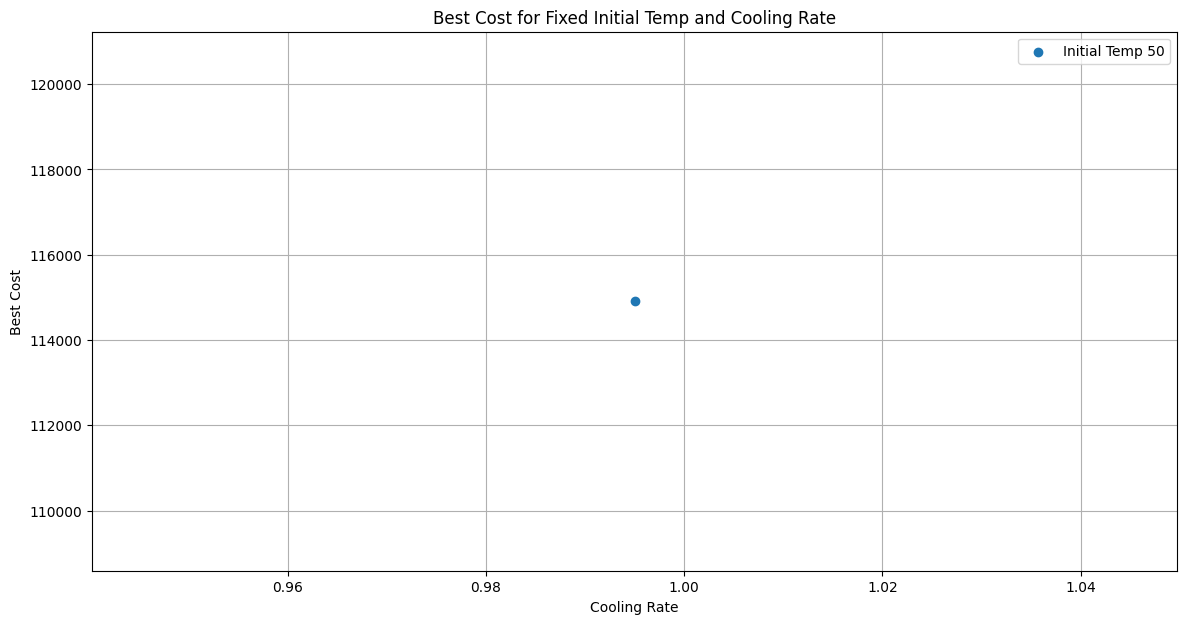

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

def main():
    distances = compute_distance_matrix(lire_fichier_tsp("pr76.tsp"))
    heuristics = [nearest_neighbor_partial, cheapest_insertion_partial, farthest_insertion_partial, random_insertion_partial, nearest_insertion_partial]

    # Fixed values for initial temperature and cooling rate
    initial_temp = 50  # Example fixed value for initial temperature
    cooling_rate = 0.995  # Example fixed value for cooling rate
    min_temp = 1

    start_time = time.time()

    best_tour, best_cost = simulated_annealing_hyper_heuristic(distances, heuristics, initial_temp, cooling_rate, min_temp)

    end_time = time.time()
    print(f'Initial Temp: {initial_temp}, Cooling Rate: {cooling_rate}, Best Cost: {best_cost}, Time Taken: {end_time - start_time} seconds')

    # Plot the results if needed (example with only one set of parameters doesn't need a plot)
    plt.figure(figsize=(14, 7))
    plt.scatter(cooling_rate, best_cost, marker='o', label=f'Initial Temp {initial_temp}')

    plt.xlabel('Cooling Rate')
    plt.ylabel('Best Cost')
    plt.title('Best Cost for Fixed Initial Temp and Cooling Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


# Les résultats obtenu : 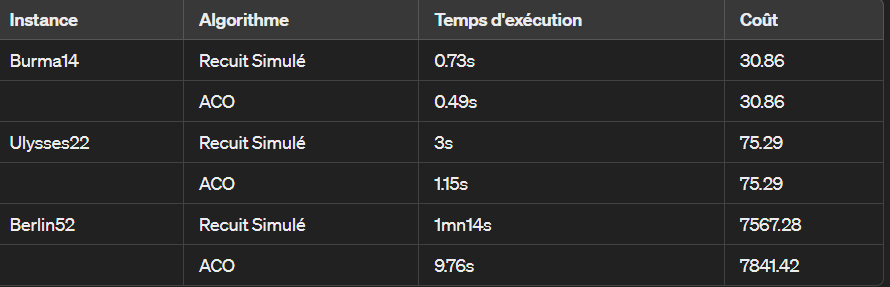
